# Twitter sentiment analysis

### Install dependecies

In [57]:
import os
import zipfile
import subprocess
from kaggle.api.kaggle_api_extended import KaggleApi
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
import tensorflow as tf
from absl import logging
import tensorflow_hub as hub
import re
from torch import nn
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from timeit import default_timer as timer 
from tqdm import tqdm

### Download dataset

In [2]:
# Ensure the Kaggle API credentials are set up
os.environ['KAGGLE_CONFIG_DIR'] = os.path.expanduser('~/.kaggle')

# Initialize the Kaggle API
api = KaggleApi()
api.authenticate()

# Download the dataset
dataset_owner = 'jp797498e/twitter-entity-sentiment-analysis'
api.dataset_download_files(dataset_owner, path='/Users/marcusandersson/Desktop/twitter_sentiment_analysis/data', unzip=True)

Dataset URL: https://www.kaggle.com/datasets/jp797498e/twitter-entity-sentiment-analysis


### Load data

In [133]:
# Load the data into a pandas DataFrame
path = '/Users/marcusandersson/Desktop/twitter_sentiment_analysis/data'
data_df = pd.read_csv(path + '/twitter_training.csv')
data_validation_df = pd.read_csv(path + '/twitter_validation.csv')

### Data cleaning

In [134]:
data_validation_df.columns = ['tweet_id', 'entity','sentiment','tweet']
data_df.columns = ['tweet_id', 'entity','sentiment','tweet']

# drop the tweet_id and entity columns
data_df = data_df.drop(['tweet_id', 'entity'], axis=1)

# Drop null values
data_df = data_df.dropna()

# Map the sentiment to a numerical value
data_df['sentiment'] = data_df['sentiment'].map({'Positive': 2, 'Neutral': 1, 'Negative': 0, 'Irrelevant': 3})


# Ensure all data typres are correct
data_df['tweet'] = data_df['tweet'].astype(str)
data_df['sentiment'] = data_df['sentiment'].astype(int)

# Check the data
print(data_df.head())

   sentiment                                              tweet
0          2  I am coming to the borders and I will kill you...
1          2  im getting on borderlands and i will kill you ...
2          2  im coming on borderlands and i will murder you...
3          2  im getting on borderlands 2 and i will murder ...
4          2  im getting into borderlands and i can murder y...


### Train test split

In [135]:
# Train test split
train_df, test_df = train_test_split(data_df, test_size=0.2, random_state=42)

# Convert to NumPy arrays
X_train = train_df['tweet'].values
y_train = train_df['sentiment'].values


X_test = test_df['tweet'].values
y_test = test_df['sentiment'].values


# Check the data
print(f'Shape of training data input: {X_train.shape}')
print(f'Shape of training data targets: {y_train.shape}')
print(f'Shape of test data input: {X_test.shape}')
print(f'Shape of test data targets: {y_test.shape}')

Shape of training data input: (59196,)
Shape of training data targets: (59196,)
Shape of test data input: (14799,)
Shape of test data targets: (14799,)


### Load Universal Sentence Encoder model

In [43]:
# Load the Universal Sentence Encoder model
embed = hub.load("https://www.kaggle.com/models/google/universal-sentence-encoder/TensorFlow2/universal-sentence-encoder/2")

ValueError: Trying to load a model of incompatible/unknown type. '/var/folders/ms/1fs2z5sj60l86m3vc7bkzmc00000gn/T/tfhub_modules/01b27d6b983e268d7ade6823c2452458cf1a12c4' contains neither 'saved_model.pb' nor 'saved_model.pbtxt'.

### Produce embeddings

In [136]:
# Compute embeddings
X_train_TF= embed(X_train)
X_test_TF = embed(X_test)

print(f'Shape of training dataset input: {X_train_TF.shape}')
print(f'Data type of training dataset input: {type(X_train_TF)}')

print(f'Shape of test dataset input: {X_test_TF.shape}')
print(f'Data type of test dataset input: {type(X_test_TF)}')

Shape of training dataset input: (59196, 512)
Data type of training dataset input: <class 'tensorflow.python.framework.ops.EagerTensor'>
Shape of test dataset input: (14799, 512)
Data type of test dataset input: <class 'tensorflow.python.framework.ops.EagerTensor'>


### Covert training dataset TF tensor to pyTorch tensor and reshape to embeddibgs of size 32x16

In [137]:
# Convert the training input to a NumPy array
X_train_np = X_train_TF.numpy()
X_train_img = np.reshape(X_train_np, (X_train_np.shape[0], 32, 16))
X_train_embd = torch.from_numpy(X_train_img)
print(f'Shape of training dataset input: {X_train_embd.shape}')

# Convert the training targets to a tensor
y_train = torch.from_numpy(y_train)
print(f'Shape of training dataset targets: {y_train.shape}')


# Convert the test input to a NumPy array
X_test_np = X_test_TF.numpy()
X_test_img = np.reshape(X_test_np, (X_test_np.shape[0], 32, 16))
X_test_embd = torch.from_numpy(X_test_img)
print(f'Shape of test dataset input: {X_test_embd.shape}')

# Convert the test targets to a tensor
y_test = torch.from_numpy(y_test)
print(f'Shape of test dataset targets: {y_test.shape}')

Shape of training dataset input: torch.Size([59196, 32, 16])
Shape of training dataset targets: torch.Size([59196])
Shape of test dataset input: torch.Size([14799, 32, 16])
Shape of test dataset targets: torch.Size([14799])


### Visialize data

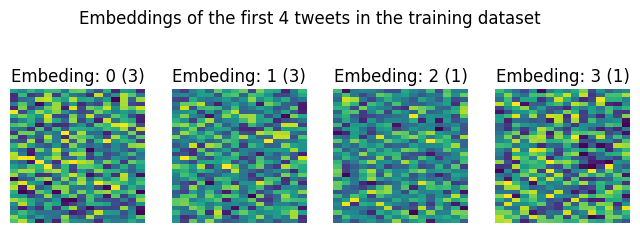

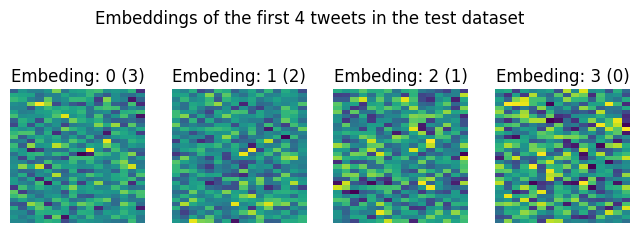

Shape of training dataset input: torch.Size([59196, 32, 16])


In [138]:
plt.figure(figsize=(8, 8))
plt.suptitle('Embeddings of the first 4 tweets in the training dataset')
for i in range(4):
    plt.subplot(4, 4, i+1)
    sns.heatmap(X_train_embd[i],  cmap='viridis', cbar=False)
    plt.axis('off')
    plt.title(f'Embeding: {i} ({y_train[i].item()})')
plt.show()

plt.figure(figsize=(8, 8))
plt.suptitle('Embeddings of the first 4 tweets in the test dataset')
for i in range(4):
    plt.subplot(4, 4, i+1)
    sns.heatmap(X_test_embd[i],  cmap='viridis', cbar=False)
    plt.axis('off')
    plt.title(f'Embeding: {i} ({y_test[i].item()})')
plt.show()

print(f'Shape of training dataset input: {X_train_embd.shape}')

### Custom dataset class

In [139]:
class SentimentAnalysisDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

# Create the training and test datasets
print(f'Shape of training dataset input: {X_train_embd.shape}')
print(f'Shape of training dataset targets: {X_train_embd.unsqueeze(0).shape}')
train_dataset = SentimentAnalysisDataset(X_train_embd.unsqueeze(1), y_train)
test_dataset = SentimentAnalysisDataset(X_test_embd.unsqueeze(1), y_test)
print(len(train_dataset))

Shape of training dataset input: torch.Size([59196, 32, 16])
Shape of training dataset targets: torch.Size([1, 59196, 32, 16])
59196


### Prepare dataloader

Feature batch shape: torch.Size([32, 1, 32, 16])
Labels batch shape: torch.Size([32])


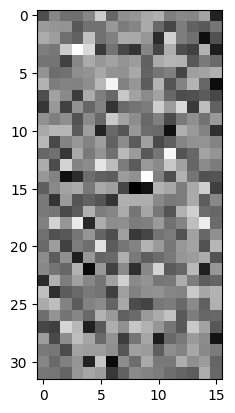

Label: 3


In [140]:
train_dataloader = DataLoader(train_dataset, batch_size=32, shuffle=True,drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=32, shuffle=False,drop_last=True)

# Display image and label.
train_features, train_labels = next(iter(test_dataloader))
print(f"Feature batch shape: {train_features.size()}")
print(f"Labels batch shape: {train_labels.size()}")
img = train_features[0].squeeze()
label = train_labels[0]
plt.imshow(img, cmap="gray")
plt.show()
print(f"Label: {label}")

In [49]:

def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

### Define training function

In [149]:
def train_model(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs, lr, device='cpu'):
    """
    Trains a PyTorch model using the specified loss function and optimizer.
    =================
    Parameters:
    model: PyTorch model
    loss_fn: PyTorch loss function
    optimizer: PyTorch optimizer
    train_dataloader: PyTorch dataloader
    test_dataloader: PyTorch dataloader
    
    num_epochs: int
    lr: float
    =================
    Returns:
    train_loss_values: list
    test_loss_values: list
    epoch_count: list
    """

    train_time_start = timer()

    # Create empty loss lists to track values
    train_loss_values = []
    test_loss_values = []
    epoch_count = []
    print(len(train_dataloader))
    for epoch in tqdm(range(num_epochs)):
        ### Training loop
        train_loss = 0

        for batch, (X, y) in enumerate(train_dataloader):
            
            
            # Set the model to training mode
            model.train()
            
            # Make a prediction
            pred = model(X)

            # Compute the loss
            loss = loss_fn(pred, y)

            # Zero the gradients
            optimizer.zero_grad()

            # Backpropagate the gradients
            loss.backward()

            # Update the weights
            optimizer.step()
            
            # if batch % 100 == 0:
            #     print(f'Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples')
            #print(f'Looked at {batch} of length {len(X)}')
            train_loss += loss.item()
        train_loss /= len(train_dataloader)

        ### Test loop
        test_loss, test_acc = 0, 0

        # Set the model to evaluation mode
        model.eval()
        # Turn off the gradients
        with torch.inference_mode():
            for X, y in test_dataloader:
                
                # Make a prediction
                test_pred = model(X)
                # Compute the loss
                test_loss += loss_fn(test_pred, y)
                # Compute the accuracy
                test_acc += (test_pred.argmax(1) == y).sum().item()
            
            test_loss /= len(test_dataloader)
            test_acc /= len(test_dataloader.dataset)


        # Print the loss every 10 epochs
        if epoch % 10 == 0:
            epoch_count.append(epoch)
            train_loss_values.append(loss.detach().numpy())
            test_loss_values.append(test_loss.detach().numpy())
            print(f'\nEpoch: {epoch} | Train Loss: {train_loss:.7f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}\n')
    train_time_end = timer()
    print(f'\nEpoch: {epoch} | Train Loss: {train_loss:.5f} | Test Loss: {test_loss:.5f} | Test Accuracy: {test_acc:.5f}\n')
    print_train_time(train_time_start, train_time_end, device)
    
    return train_loss_values, test_loss_values, epoch_count

### Evaluation function

In [51]:
def eval_model(model: torch.nn.Module, 
               data_loader: torch.utils.data.DataLoader, 
               loss_fn: torch.nn.Module, 
               accuracy_fn):
    """Returns a dictionary containing the results of model predicting on data_loader.

    Args:
        model (torch.nn.Module): A PyTorch model capable of making predictions on data_loader.
        data_loader (torch.utils.data.DataLoader): The target dataset to predict on.
        loss_fn (torch.nn.Module): The loss function of model.
        accuracy_fn: An accuracy function to compare the models predictions to the truth labels.

    Returns:
        (dict): Results of model making predictions on data_loader.
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            # Make predictions with the model
            y_pred = model(X)
            
            # Accumulate the loss and accuracy values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, 
                                y_pred=y_pred.argmax(dim=1)) # For accuracy, need the prediction labels (logits -> pred_prob -> pred_labels)
        
        # Scale loss and acc to find the average loss/acc per batch
        loss /= len(data_loader)
        acc /= len(data_loader)
        
    return {"model_name": model.__class__.__name__, # only works when model was created with a class
            "model_loss": loss.item(),
            "model_acc": acc}


### Sentiment Analisys model

In [164]:
class SentimentAnalisysModel(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int, conv_kernel: int, pool_kernel: int):
        super().__init__()

        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=(conv_kernel, conv_kernel),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=(conv_kernel, conv_kernel),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(pool_kernel, pool_kernel),
                         stride=2)
            )
        
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units*2,
                      kernel_size=(conv_kernel, conv_kernel),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units*2,
                      out_channels=hidden_units*2,
                      kernel_size=(conv_kernel, conv_kernel),
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=(pool_kernel, pool_kernel),
                         stride=2)
            )
        
        self.classifier = nn.Sequential(
            nn.Flatten(),
    
            nn.Linear(hidden_units*2*5, 64),
            nn.ReLU(),
            nn.Linear(64, output_shape)
        )
    
    def forward(self, x):
        
        x = self.block1(x)
        x = self.block2(x)
       
        x = self.classifier(x)
        return x



        

In [165]:
model = SentimentAnalisysModel(input_shape=1, hidden_units=16, output_shape=4, conv_kernel=5, pool_kernel=2)
model

SentimentAnalisysModel(
  (block1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(16, 16, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 32, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=(2, 2), stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=160, out_features=64, bias=True)
    (2): ReLU()
    (3): Linear(in_features=64, out_features=4, bias=True)
  )
)

### Setup loss function and optimizer

In [166]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [167]:
train_loss, test_loss, epoch_count = train_model(model, loss_fn, optimizer, train_dataloader, test_dataloader, num_epochs=100, lr=0.01)

1849


  1%|          | 1/100 [00:22<37:14, 22.57s/it]


Epoch: 0 | Train Loss: 1.3671475 | Test Loss: 1.36806 | Test Accuracy: 0.30130



 11%|█         | 11/100 [04:07<33:19, 22.46s/it]


Epoch: 10 | Train Loss: 1.3670462 | Test Loss: 1.36791 | Test Accuracy: 0.30130



 21%|██        | 21/100 [07:52<29:35, 22.48s/it]


Epoch: 20 | Train Loss: 1.3671838 | Test Loss: 1.36859 | Test Accuracy: 0.30130



 21%|██        | 21/100 [08:03<30:20, 23.05s/it]


KeyboardInterrupt: 

### Plot loss and accuracy

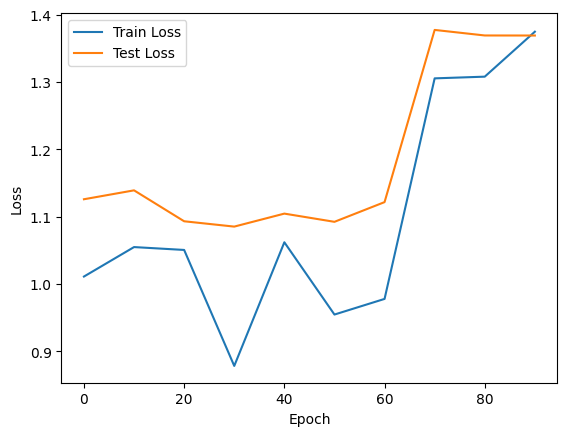

In [155]:
def plot_loss(train_loss, test_loss, epoch_count):
    plt.plot(epoch_count, train_loss, label='Train Loss')
    plt.plot(epoch_count, test_loss, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_loss(train_loss, test_loss, epoch_count)

### Make some predictions

In [168]:
for n in range(5):
    pred = model(test_dataloader.dataset[n][0].unsqueeze(0))
    print(f'Tweet: {X_test[n]}| Predicted: {pred.argmax(1).item()} | Truth: {y_test[n].item()}')

Tweet: Do you think you can hurt me?| Predicted: 0 | Truth: 3
Tweet: About The time!!| Predicted: 0 | Truth: 2
Tweet: Calls from _ z1rv _ & @ Tweet98 got me this sore ass.| Predicted: 0 | Truth: 1
Tweet: So CoD: Black Ops Cold War is gonna be ass? @ RealThunder402 where are we dropping at?| Predicted: 0 | Truth: 0
Tweet: Y HAPPY ABOUT THIS.| Predicted: 0 | Truth: 0
